# Linear Regression
### EK 10/26

Using all features to predict attention with linear regression.

### Imports

In [33]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from warnings import filterwarnings
filterwarnings('ignore')



### Read in data

In [34]:
games = pd.read_csv("/Users/elisabethkollrack/Thesis/EK-thesis/game_attention.csv")
# adjust attention
# take log of attention
games['log_attention'] = np.log1p(games['attention'])


In [48]:
games

,date,game_id,season,week,weekday,gametime,home_team,away_team,home_win_pct,away_win_pct,num_lead_changes,total_score,score_differential,overtime,attention,log_attention
0,2013-09-05,2013_01_BAL_DEN,2013,1,Thursday,2030,DEN,BAL,0.000000,0.000000,1,76,22,0,5800,8.665786
1,2013-09-08,2013_01_NE_BUF,2013,1,Sunday,1300,BUF,NE,0.000000,0.000000,2,44,2,0,592,6.385194
2,2013-09-08,2013_01_SEA_CAR,2013,1,Sunday,1300,CAR,SEA,0.000000,0.000000,2,19,5,0,265,5.583496
3,2013-09-08,2013_01_CIN_CHI,2013,1,Sunday,1300,CHI,CIN,0.000000,0.000000,2,45,3,0,316,5.758902
4,2013-09-08,2013_01_MIA_CLE,2013,1,Sunday,1300,CLE,MIA,0.000000,0.000000,2,33,13,0,429,6.063785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,2017-12-31,2017_17_OAK_LAC,2017,17,Sunday,1625,LAC,OAK,0.533333,0.400000,2,40,20,0,1464,7.289611
1276,2017-12-31,2017_17_BUF_MIA,2017,17,Sunday,1625,MIA,BUF,0.400000,0.533333,0,38,6,0,1308,7.177019
1277,2017-12-31,2017_17_ARI_SEA,2017,17,Sunday,1625,SEA,ARI,0.600000,0.466667,2,50,2,0,192,5.262690
1278,2017-12-31,2017_17_NO_TB,2017,17,Sunday,1625,TB,NO,0.266667,0.733333,4,55,7,0,1619,7.390181


### Adjust game time to minutes and date to datetime format

In [35]:
games['gametime'] = games['gametime'].str.replace(':', '').astype(int)
games['date'] = pd.to_datetime(games['date'])

### Encode categorical features

In [36]:
categorical_cols = ['weekday', 'home_team', 'away_team']
games_encoded = pd.get_dummies(games, columns=categorical_cols, drop_first=True)


### Visualize numeric features

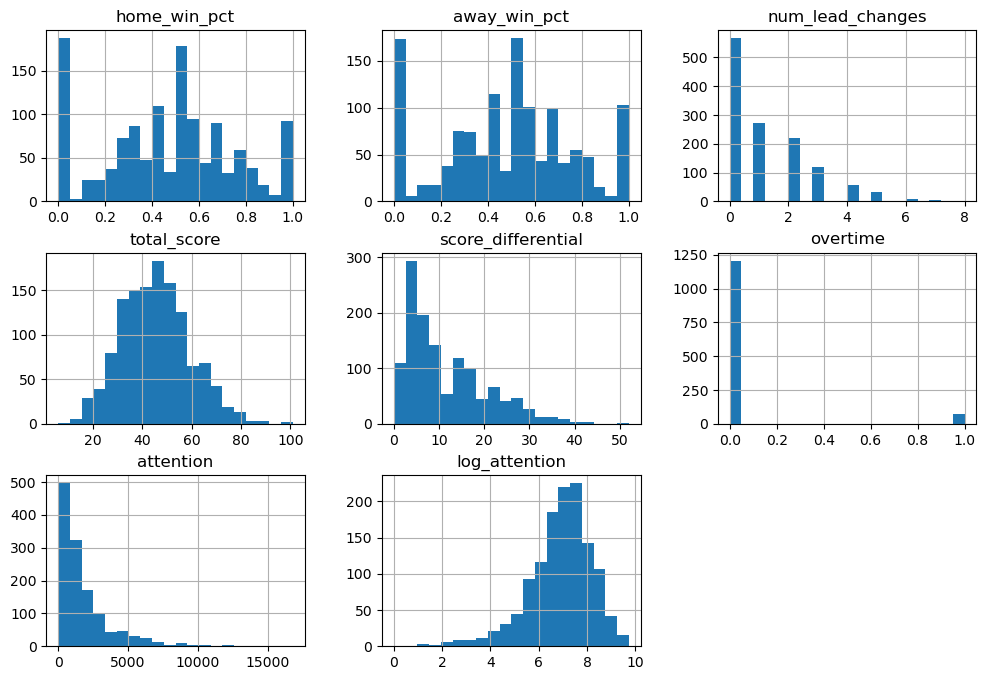

In [37]:

numeric_cols = ['home_win_pct','away_win_pct','num_lead_changes','total_score','score_differential','overtime','attention', 'log_attention']
games[numeric_cols].hist(figsize=(12,8), bins=20)
plt.show()

- Attention is right skewed, so I took the log of it and it looks more normal
- Score differential and # of lead changes are also right skewed

### Correlation Analysis

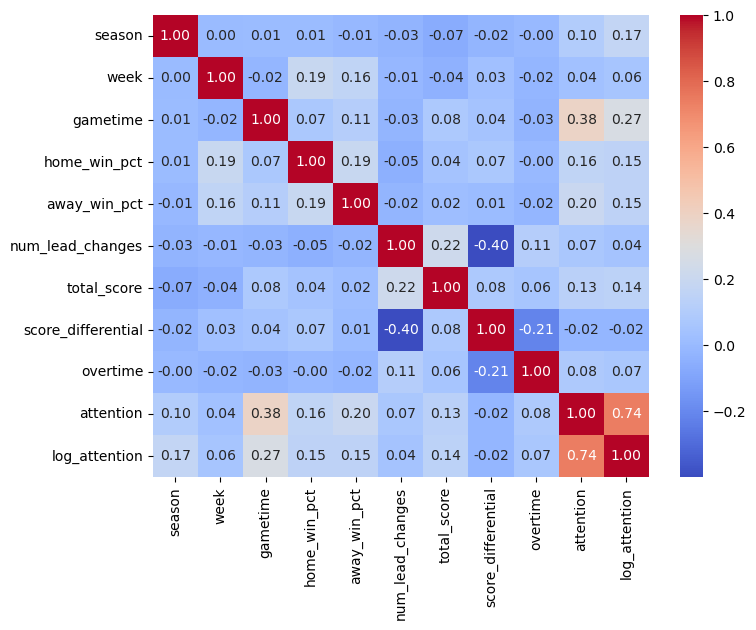

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(games_encoded.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


- Highest correlation (-0.40) between number of lead changes and score differential and attention and log attention (expected)

### Attention by Weekday

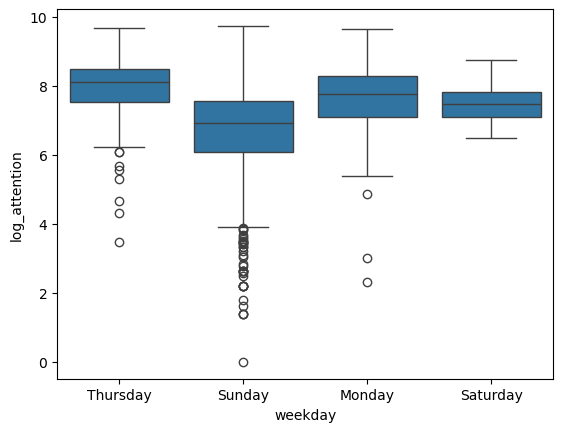

In [39]:
sns.boxplot(x='weekday', y='log_attention', data=games)
plt.show()


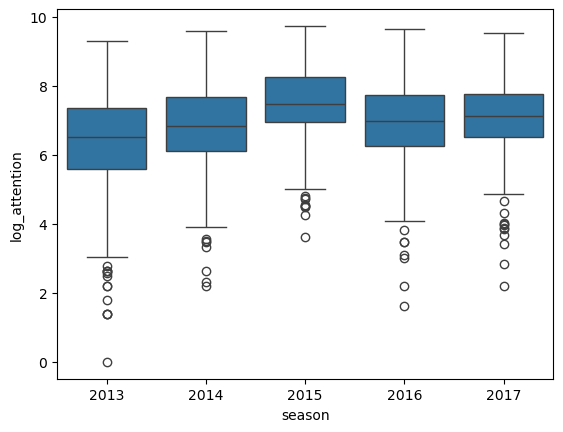

In [40]:
sns.boxplot(x='season', y='log_attention', data=games)
plt.show()

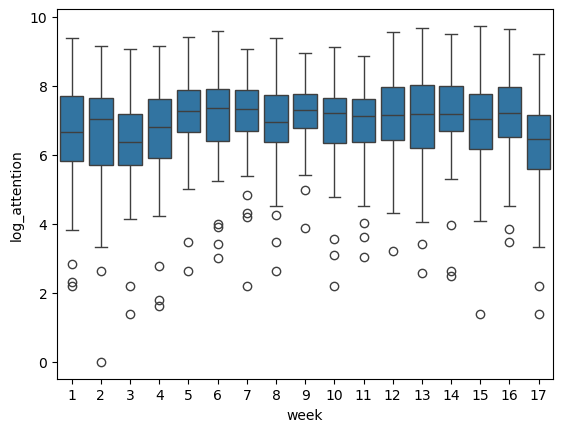

In [41]:
sns.boxplot(x='week', y='log_attention', data=games)
plt.show()

### Check for multicollinearity

In [42]:
X = games_encoded.select_dtypes(include='number').drop(columns=['attention', 'log_attention'])
vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values(by='VIF', ascending=False)


,feature,VIF
0,season,43.264828
2,gametime,29.488069
6,total_score,12.903345
1,week,4.544298
4,away_win_pct,4.101829
3,home_win_pct,3.943138
7,score_differential,3.374395
5,num_lead_changes,2.198451
8,overtime,1.121010


- Need to think about multicollinearity with season, gametime, and total_score.

## Linear Regression

In [43]:
# Drop irrelevant columns
X = games_encoded.drop(columns=['attention','log_attention', 'game_id', 'date'])  # only numeric/coded features
y = games_encoded['log_attention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 0.8152070050319246
R^2: 0.6241040353277327


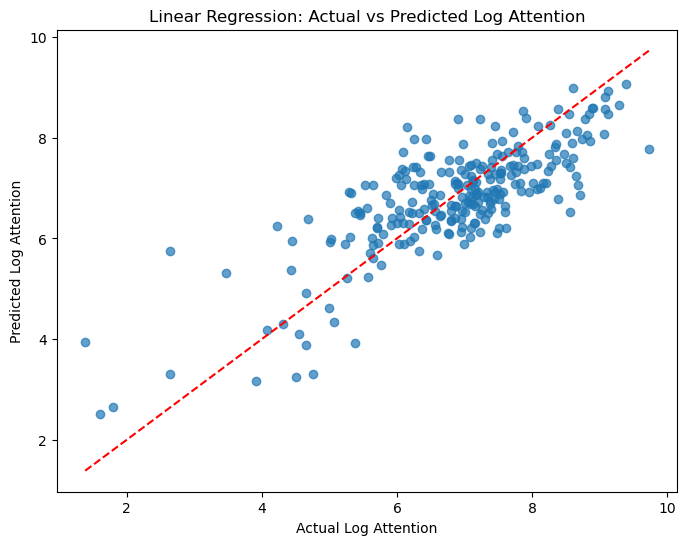

In [44]:
# plot linear regression model
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Log Attention")
plt.ylabel("Predicted Log Attention")
plt.title("Linear Regression: Actual vs Predicted Log Attention")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


In [45]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_})
coefficients.sort_values(by='Coefficient', ascending=False)


,Feature,Coefficient
22,home_team_GB,4.353836
19,home_team_DAL,4.313999
31,home_team_NE,4.264028
39,home_team_SEA,4.226736
32,home_team_NO,3.887344
...,...,...
1,week,0.009141
6,total_score,0.007857
2,gametime,0.000637
7,score_differential,-0.001144


- More popular teams with higher coefficients... makes sense (I think?)

### Residual analysis

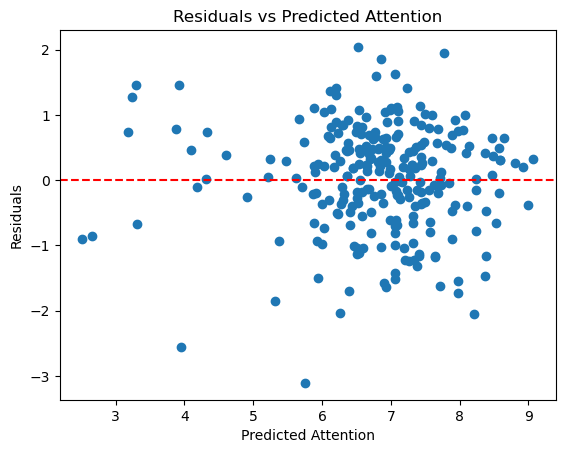

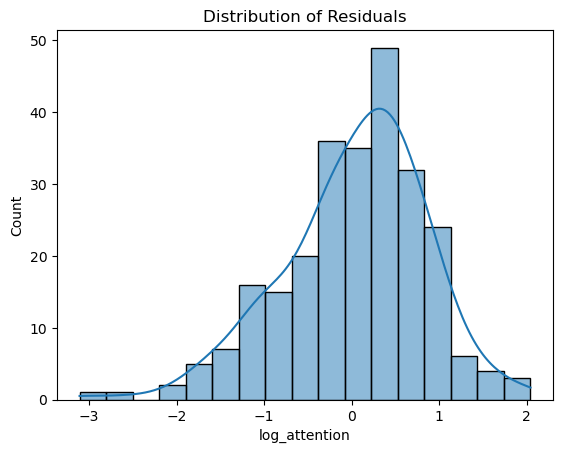

In [46]:
# Residual analysis 
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Attention")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Attention")
plt.show()
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()


### LR with Interaction Terms

In [47]:
# interaction terms
X['home_away_win_interaction'] = X['home_win_pct'] * X['away_win_pct']
X['lead_diff_interaction'] = X['num_lead_changes'] * X['score_differential']
X['total_score_leads_interaction'] = X['total_score'] * X['num_lead_changes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("With Selective Interaction Terms:")
print("RMSE:", rmse)
print("R^2:", r2)


With Selective Interaction Terms:
RMSE: 0.8208247105219808
R^2: 0.6189054815181103
